# Argonne Lab Talk 

Computations and figures for a semnar at Argonne Lab

presented on Thursday, May 18, 2023, [slides here](https://speakerdeck.com/fjhickernell/how-much-to-sample-to-estimate-the-mean)

## Import the necessary packages and set up plotting routines

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as Nintegrate
import qmcpy as qp
from sympy import * #so that we can do symbolic integration
import time  #timing routines
import warnings  #to suppress warnings when needed
import pickle  #write output to a file and load it back in
from copy import deepcopy
from matplotlib.patches import Polygon

plt.rc('font', size=16)  #set defaults so that the plots are readable
plt.rc('font', serif = "Computer Modern Roman")
plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm}')
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

#a helpful plotting method to show increasing numbers of points
def plot_successive_points(distrib,ld_name,first_n=64,n_cols=1,
                           pt_clr=['tab:blue', 'tab:green', 'k', 'tab:cyan', 'tab:purple', 'tab:orange'],
                           xlim=[0,1],ylim=[0,1],ntitle=True,titleText=''):
  fig,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(5*n_cols,5.5))
  if n_cols==1: ax = [ax]
  last_n = first_n*(2**n_cols)
  points = distrib.gen_samples(n=last_n)
  for i in range(n_cols):
    n = first_n
    nstart = 0
    for j in range(i+1):
      n = first_n*(2**j)
      ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[j])
      nstart = n
    if ntitle == True:
        ax[i].set_title('n = %d'%n)
    else:
        ax[i].set_title(titleText)
    ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,1}$')
    ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,2}$')
    ax[i].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
  if ld_name != "":
    fig.suptitle('%s Points'%ld_name, y=0.87)
  return fig
print('QMCPy Version',qp.__version__)

QMCPy Version 1.4


### Set the path to save the figures here

In [2]:
figpath = '' #this path sends the figures to the directory that you want

## Trapezoidal rule and its error

### Define test function

In [3]:
x = Symbol('x')                       #do some symbolic computation 
fsim = 30*x*exp(-5*x)                 #our test function
intf = N(integrate(fsim, (x, 0, 1)))  #and its integral
print(intf)

1.15148678160658


### Plot test function and trapezoidal rule

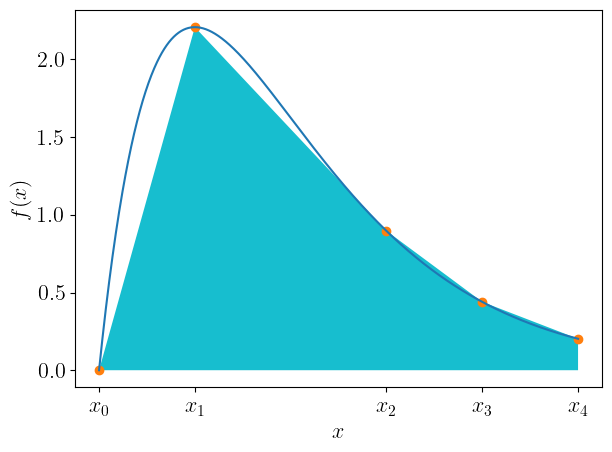

In [4]:
f = lambdify(x,fsim)                     #make it a numeric function
xnodes = np.array([0, 0.2, 0.6, 0.8, 1]) #choose nodes to apply the trapezoidla rule
fnodes = f(xnodes)                       #function values at those nodes
xplot = np.linspace(0, 1, 1000)          #nodes for polotting our function
fig,ax = plt.subplots()
xfpatch = np.append(np.transpose(np.array([xnodes, fnodes])),[[1,0]],axis=0)  #the trapezoidal rule approximation
ax.add_patch(Polygon(xfpatch,facecolor='tab:cyan'))  #plot the trapezoidal rule
plt.plot(xplot, f(xplot), color='tab:blue')          #and the function
plt.scatter(xnodes, fnodes, color='tab:orange')     #and the nodes
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
xlabels = []
for i in range(xnodes.size): xlabels.append(f'$x_{i}$')    
ax.set_xticks(xnodes,labels = xlabels) 
plt.tight_layout() 
fig.savefig(figpath+'traprule.eps',format='eps')

### Compute trapezoidal rule and its error

In [6]:
xdiff = np.diff(xnodes)
trap_rule = np.sum((fnodes[:-1]*xdiff+fnodes[1:]*xdiff)/2)
err_trap = intf - trap_rule 
print(err_trap)

0.112324710648342


### Compute elements of the trio identity

150*(5*x - 2)*exp(-5*x)
True
[0.150522653770521, 0.019999999999999997, 37.3115633543065]


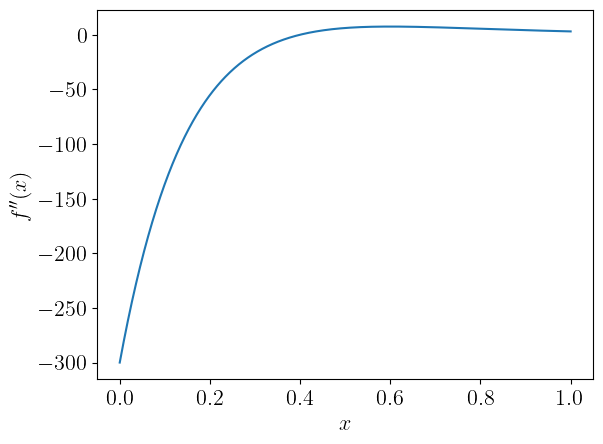

In [7]:
discrepancy = np.max(xdiff**2)/8                          #quality of the nodes
f2diffsim = diff(fsim,x,2)
print(f2diffsim)
f2diff = lambdify(x,f2diffsim) 
fig,ax = plt.subplots()
plt.plot(xplot, f2diff(xplot), color='tab:blue')
ax.set_xlabel('$x$')
ax.set_ylabel("$f''(x)$");
variation = N(integrate(abs(f2diffsim), (x, 0, 1)))   #roughness of the integrand
Nvariation = Nintegrate.quad(lambda x: abs(f2diff(x)),0,1,epsabs = 1e-14)  #checking whether the symbolic integration is correct
print(abs(Nvariation[0]-variation) <= 1e-10)          #do the symbolic and numerical integration methods agree
confound = err_trap/(discrepancy*variation)           #how unlucky the integrand is, should be between -1 and +1
print([confound,discrepancy, variation])              #the trapezoidal rule error is the product of these three numbers
fig.savefig(figpath+'traprulef2.eps',format='eps')

## Here are some plots of IID and Low Discrepancy (LD) Points
### Lattice points first

[[0.67637789 0.89133206 0.06025741 0.8803315  0.8122234 ]
 [0.17637789 0.39133206 0.56025741 0.3803315  0.3122234 ]
 [0.92637789 0.64133206 0.81025741 0.1303315  0.0622234 ]
 [0.42637789 0.14133206 0.31025741 0.6303315  0.5622234 ]
 [0.80137789 0.26633206 0.43525741 0.0053315  0.9372234 ]
 [0.30137789 0.76633206 0.93525741 0.5053315  0.4372234 ]
 [0.05137789 0.01633206 0.18525741 0.2553315  0.1872234 ]
 [0.55137789 0.51633206 0.68525741 0.7553315  0.6872234 ]
 [0.73887789 0.57883206 0.24775741 0.9428315  0.3747234 ]
 [0.23887789 0.07883206 0.74775741 0.4428315  0.8747234 ]
 [0.98887789 0.32883206 0.99775741 0.1928315  0.6247234 ]
 [0.48887789 0.82883206 0.49775741 0.6928315  0.1247234 ]
 [0.86387789 0.95383206 0.62275741 0.0678315  0.4997234 ]
 [0.36387789 0.45383206 0.12275741 0.5678315  0.9997234 ]
 [0.11387789 0.70383206 0.37275741 0.3178315  0.7497234 ]
 [0.61387789 0.20383206 0.87275741 0.8178315  0.2497234 ]]


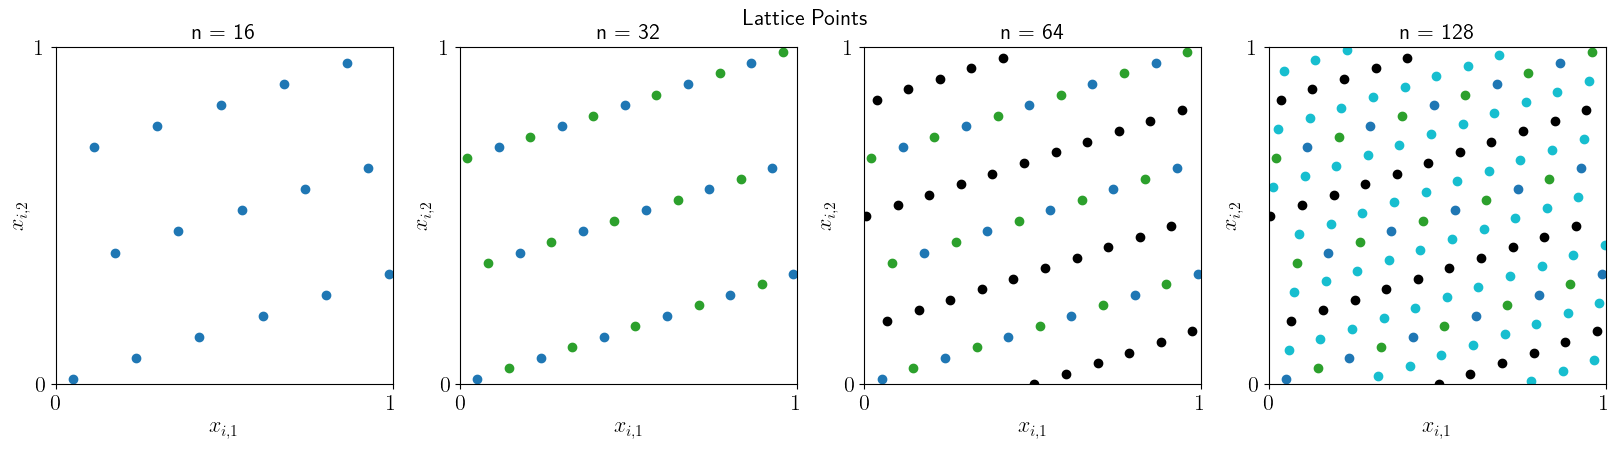

In [9]:
d = 5 #dimension
n = 16 #number of points
ld = qp.Lattice(d) #define the generator
xpts = ld.gen_samples(n) #generate points
print(xpts)
fig = plot_successive_points(ld,'Lattice',first_n=n,n_cols=4)
fig.savefig(figpath+'latticepts.eps',format='eps')

### Next Sobol' points

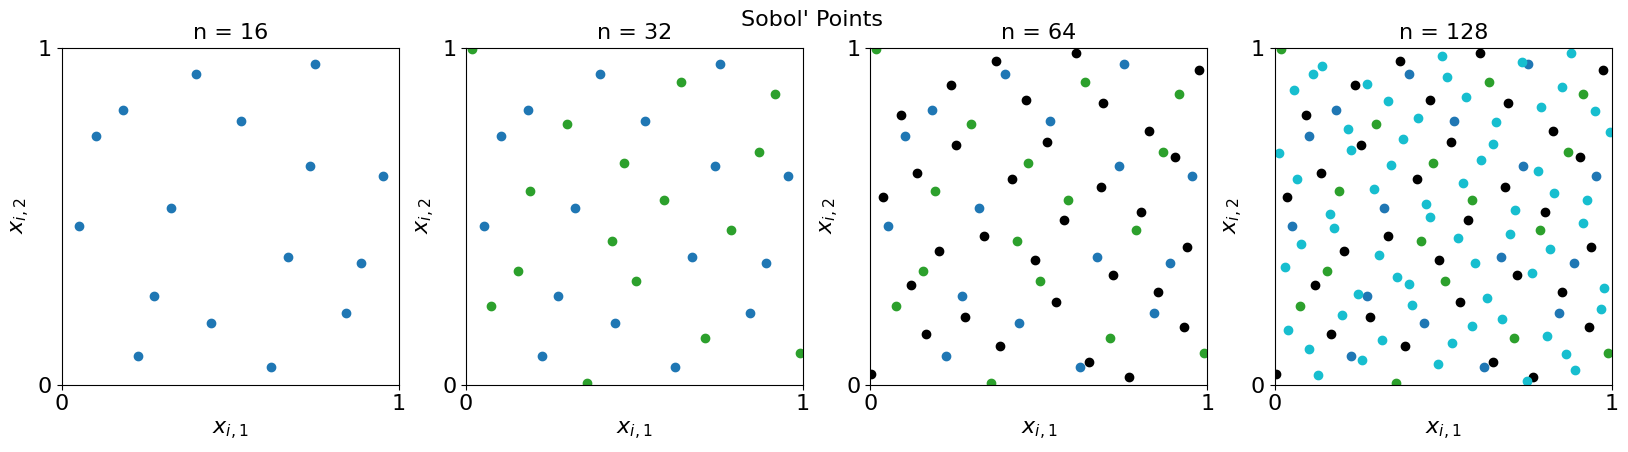

In [18]:
ld = qp.Sobol(d) #define the generator
xpts_Sobol = ld.gen_samples(n) #generate points
fig = plot_successive_points(ld,'Sobol\'',first_n=n,n_cols=4)
fig.savefig(figpath+'sobolpts.eps',format='eps')

### Compare to IID

Note that there are more gaps and clusters

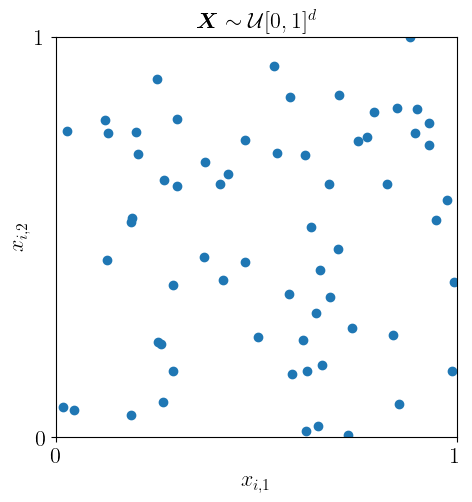

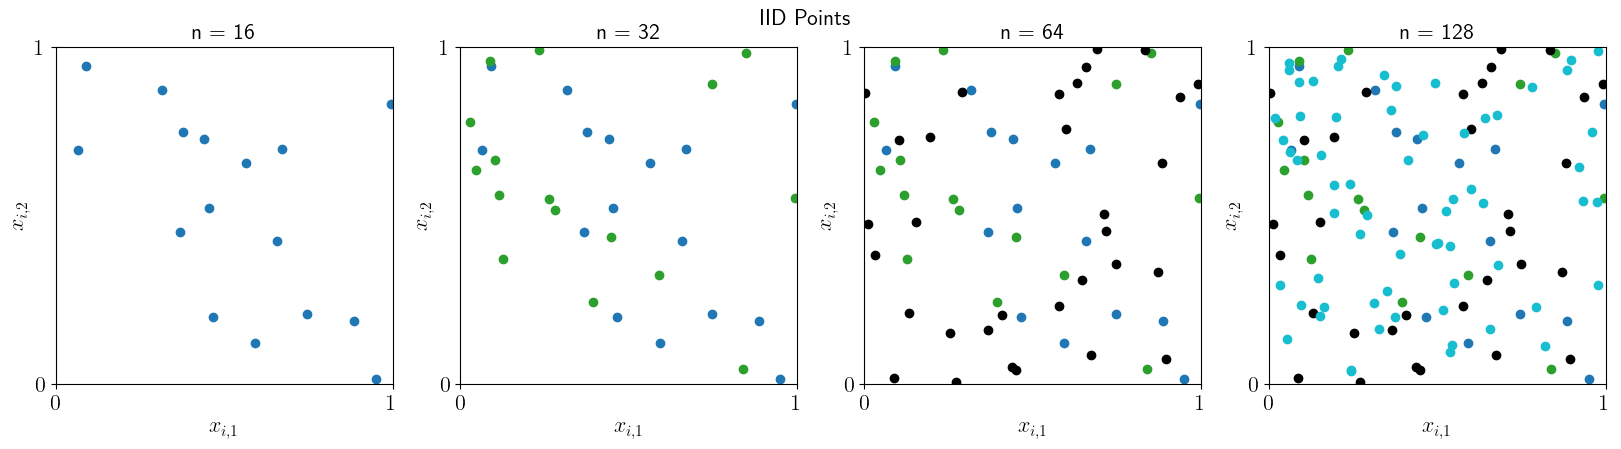

In [59]:
iid = qp.IIDStdUniform(d) #define the generator
xpts = ld.gen_samples(n) #generate points
xpts
fig = plot_successive_points(iid,'',first_n=4*n,n_cols=1,ntitle=False,titleText='$\\boldsymbol{X} \sim \mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'iidptssingle.eps',format='eps')
fig = plot_successive_points(iid,'IID',first_n=n,n_cols=4)
fig.savefig(figpath+'iidptsseq.eps',format='eps')

## Beam Example Figures

Using computations done below

### Plot the time and sample size required to solve for the deflection of the end point using IID and low discrepancy 

[1037.12106673]


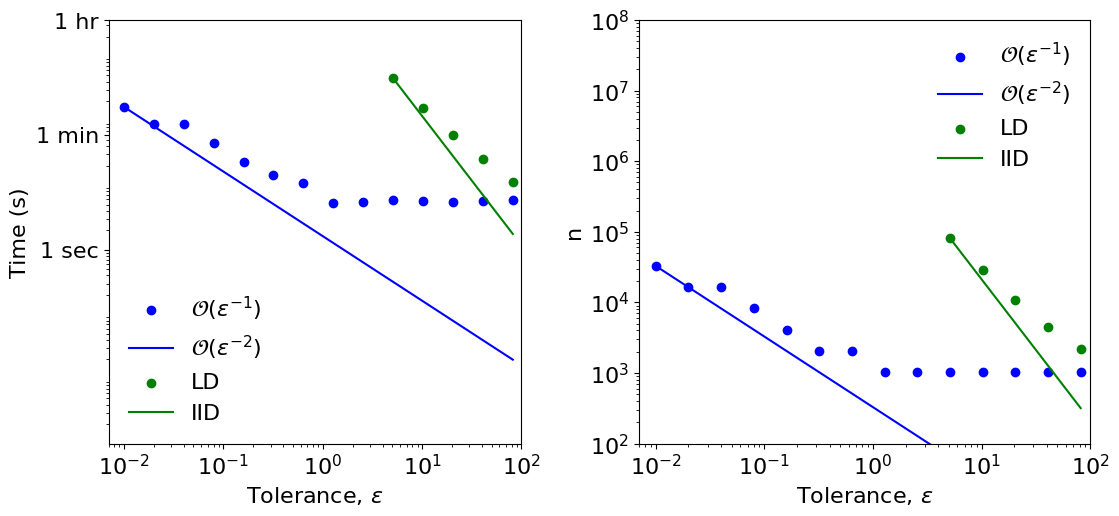

In [20]:
with open(figpath+'iid_ld.pkl','rb') as myfile: tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='b'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
ax[0].scatter(tol_vec[ii_iid:n_tol],iid_time[ii_iid:n_tol],color='g'); 
ax[0].plot(tol_vec[ii_iid:n_tol],[(iid_time[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[0].set_ylim([0.001,1000]); ax[0].set_ylabel('Time (s)')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='b'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
ax[1].scatter(tol_vec[ii_iid:n_tol],iid_n[ii_iid:n_tol],color='g'); 
ax[1].plot(tol_vec[ii_iid:n_tol],[(iid_n[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[1].set_ylim([1e2,1e8]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,100]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend([r'$\mathcal{O}(\varepsilon^{-1})$',r'$\mathcal{O}(\varepsilon^{-2})$','LD','IID'],frameon=False)
  ax[ii].set_aspect(0.65)
ax[0].set_yticks([1, 60, 3600], labels = ['1 sec', '1 min', '1 hr'])    
fig.savefig(figpath+'iidldbeam.eps',format='eps',bbox_inches='tight')

### Plot the time and sample size required to solve for the deflection of the whole beam using low discrepancy with and without parallel

[1037.12106673]


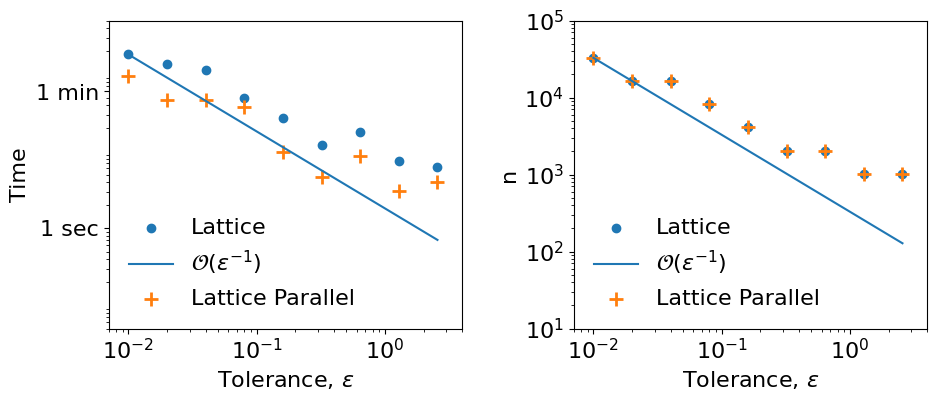

In [21]:
with open(figpath+'ld_parallel.pkl','rb') as myfile: tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='tab:blue'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[0].scatter(tol_vec[0:n_tol],ld_p_time[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[0].plot(tol_vec[0:n_tol],[(ld_p_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[0].set_ylim([0.05,500]); ax[0].set_ylabel('Time')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='tab:blue'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[1].scatter(tol_vec[0:n_tol],ld_p_n[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[1].plot(tol_vec[0:n_tol],[(ld_p_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[1].set_ylim([10,1e5]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,4]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend(['Lattice',r'$\mathcal{O}(\varepsilon^{-1})$','Lattice Parallel',r'$\mathcal{O}(\varepsilon^{-1})$'],frameon=False)
  ax[ii].set_aspect(0.6)
ax[0].set_yticks([1, 60], labels = ['1 sec', '1 min'])
fig.savefig(figpath+'ldparallelbeam.eps',format='eps',bbox_inches='tight')

### Plot of beam solution

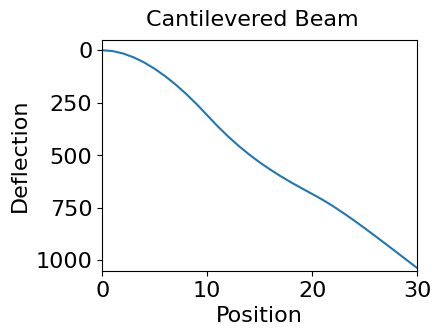

In [22]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(best_solution,'-')
ax.set_xlim([0,len(best_solution)-1]); ax.set_xlabel('Position')
ax.set_ylim([1050,-50]);  ax.set_ylabel('Deflection');
ax.set_aspect(0.02)
fig.suptitle('Cantilevered Beam')
fig.savefig(figpath+'cantileveredbeamwords.eps',format='eps',bbox_inches='tight')

In [10]:
qp.util.stop_notebook()

Type 'yes' to continue running notebookyes


*Below is long-running code, that we rarely wish to run*

## Beam Example Computations
### Set up the problem using a docker container to solve the ODE

To run this, you need to be running the docker application, https://www.docker.com/products/docker-desktop/

In [12]:
import umbridge #this is the connector
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest #get beam example
d = 3 #dimension of the randomness
lb = 1 #lower bound on randomness
ub = 1.2 #upper bound on randomness
umbridge_config = {"d": d}
model = umbridge.HTTPModel('http://localhost:4243','forward') #this is the original model
outindex = -1 #choose last element of the vector of beam deflections
modeli = deepcopy(model) #and construct a model for just that deflection
modeli.get_output_sizes = lambda *args : [1]
modeli.get_output_sizes()
modeli.__call__ = lambda *args,**kwargs: [[model.__call__(*args,**kwargs)[0][outindex]]]

docker: Error response from daemon: Conflict. The container name "/muqbp" is already in use by container "7f9e0237bd3e72783743efb67f78ce8cc800f5a24835f4191bc423f960cdedac". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


### First we compute the time required to solve for the deflection of the end point using IID and low discrepancy 

In [13]:
ld = qp.Uniform(qp.Lattice(d,seed=7),lower_bound=lb,upper_bound=ub) #lattice points for this problem
ld_integ = qp.UMBridgeWrapper(ld,modeli,umbridge_config,parallel=False) #integrand
iid = qp.Uniform(qp.IIDStdUniform(d),lower_bound=lb,upper_bound=ub) #iid points for this problem
iid_integ = qp.UMBridgeWrapper(iid,modeli,umbridge_config,parallel=False) #integrand
tol = 0.01  #smallest tolerance

n_tol = 14  #number of different tolerances
ii_iid = 9  #make this larger to reduce the time required by not running all cases for IID
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
iid_time = [0]*n_tol; iid_n = [0]*n_tol  #IID time and number of function values
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution_i = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  if ii >= ii_iid:
    solution, data = qp.CubMCG(iid_integ, abs_tol = tol_vec[ii]).integrate()
    iid_time[ii] = data.time_integrate
    iid_n[ii] = data.n_total
  print(ii, end = ' ')
with open(figpath+'iid_ld.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i],myfile)


Cantilever Beam

iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

### Next, we compute the time required to solve for the deflection of the whole beam using low discrepancy with and without parallel

In [14]:
ld_integ = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=False) #integrand
ld_integ_p = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=8) #integrand with parallel processing

tol = 0.01
n_tol = 9  #number of different tolerances
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
ld_p_time = [0]*n_tol; ld_p_n = [0]*n_tol  #low discrepancy time and number of function values with parallel
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  solution, data = qp.CubQMCLatticeG(ld_integ_p, abs_tol = tol_vec[ii]).integrate()
  ld_p_time[ii] = data.time_integrate
  ld_p_n[ii] = data.n_total
  print(ii, end = ' ') 
with open(figpath+'ld_parallel.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution],myfile)


Cantilever Beam

iteration 0 1 2 3 4 5 6 7 8 

### Shut down docker

In [ ]:
!docker rm -f muqbp #shut down docker image